In [1]:
import algo
import datamodel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)

In [2]:
days = list(range(-2, 1))
outputs = {}
class Data:
    def __init__(self, df):
        self.output = df
        self.times = df['timestamp'].unique()
        self.products = df['product'].unique()
        self.mtm_value = pd.DataFrame(index = df['timestamp'].unique())
        self.mtm_value.index.name = 'Time'
        self.mtm_value['Cash'] = 0
        self.mtm_value['Value'] = 0
        for product in self.products:
            self.mtm_value[product]=0
            self.mtm_value["Cash_"+product]=0
            self.mtm_value["Value_"+product]=0
for day in days:
    fname = f"Data/prices_round_1_day_{day}.csv"
    df = pd.read_csv(fname, index_col=False, sep=";")
    outputs[day] = Data(df)

In [3]:
assets = {
    "PEARLS":algo.Asset(20, 10, 10),
    "BANANAS":algo.Asset(20, 90, 15),
}

In [4]:
trader = algo.Trader()
print(trader.asset_dicts["BANANAS"])

Limit 20 long average 90 short average 15
[]
[]


In [5]:
for output in outputs.values():
    position = {}
    trader = algo.Trader(
    {"PEARLS":algo.Asset(20, 10, 10),
    "BANANAS":algo.Asset(20, 90, 15)}) #
    print(trader.asset_dicts["BANANAS"])
    for time in output.times:
        # print(time)
        listings = {}
        order_depths = {}
        own_trades = {}
        market_trades = {}
        observations = {}
        for product in output.products:
            # print(data)
            depth = datamodel.OrderDepth()
            data = output.output[:][(output.output['timestamp']  ==time)& (output.output['product']==product)]
            try:
                depth.buy_orders = {int(data["bid_price_1"]):int(data["bid_volume_1"]), int(data["bid_price_2"]):int(data["bid_volume_2"]), int(data["bid_price_3"]):int(data["bid_volume_3"])}
            except:
                try:
                    depth.buy_orders = {int(data["bid_price_1"]):int(data["bid_volume_1"]), int(data["bid_price_2"]):int(data["bid_volume_2"])}
                except:
                    depth.buy_orders = {int(data["bid_price_1"]):int(data["bid_volume_1"])}
            try:
                depth.sell_orders = {int(data["ask_price_1"]):-int(data["ask_volume_1"]), int(data["ask_price_2"]):-int(data["ask_volume_2"]), int(data["ask_price_3"]):-int(data["ask_volume_3"])}
            except:
                try:
                    depth.sell_orders = {int(data["ask_price_1"]):-int(data["ask_volume_1"]), int(data["ask_price_2"]):-int(data["ask_volume_2"])}
                except:
                    depth.sell_orders = {int(data["ask_price_1"]):-int(data["ask_volume_1"])}
            order_depths[product] = depth
        state = datamodel.TradingState(
                    timestamp= time,
                    listings= listings,
                    order_depths= order_depths,
                    own_trades= own_trades,
                    market_trades= market_trades,
                    position= position,
                    observations= observations)
        trades = trader.run(state = state)
        # breakdown by product
        cash_bd = {}
        value_bd = {}
        for product in output.products:
            cash_bd[product]= output.mtm_value.loc[time]['Cash_'+product]
        for trade in trades:
            if trade not in position:
                try:
                    position[trade] =  trades[trade][0].quantity
                    cash_bd[trade] += -trades[trade][0].quantity*trades[trade][0].price
                except:
                    continue
            else:
                try:
                    position[trade] += trades[trade][0].quantity
                    cash_bd[trade] += -trades[trade][0].quantity*trades[trade][0].price
                except:
                    continue
        # breakdown by product
        for product in output.products:
            value_bd[product]= cash_bd[product]
        # mtm valuation using best price to have no net assets
        for asset, pos in position.items():
            output.mtm_value.loc[time][asset] = pos
            if pos<0:
                value_bd[asset] += pos*min(order_depths[asset].sell_orders.keys())
            if pos>0:
                value_bd[asset] += pos*max(order_depths[asset].sell_orders.keys())


        output.mtm_value.loc[time]['Value'] = sum(value_bd.values())
        output.mtm_value.loc[time]['Cash'] = sum(cash_bd.values())
        for product in output.products:
            output.mtm_value.loc[time]['Cash_'+product] = cash_bd[product]
            output.mtm_value.loc[time]['Value_'+product] = value_bd[product]
        try:
            output.mtm_value.loc[time+100]['Cash'] = output.mtm_value.loc[time]['Cash']
            output.mtm_value.loc[time+100]['Value'] = output.mtm_value.loc[time]['Cash']
            for product in output.products:
                output.mtm_value.loc[time+100]['Cash_'+product] = cash_bd[product]
                output.mtm_value.loc[time+100]['Value_'+product] = cash_bd[product]
        except:
            continue

Limit 20 long average 90 short average 15
[]
[]
BUY PEARLS 3x 9998
SELL PEARLS 1x 10002
BUY PEARLS 3x 9998
SELL PEARLS 1x 10002
BUY PEARLS 1x 9998
SELL PEARLS 3x 10002
SELL PEARLS 1x 10002
SELL PEARLS 1x 10002
BUY PEARLS 6x 9998
SELL PEARLS 1x 10002
delta 5002.188888888889 5000.066666666667
delta 5002.188888888889 5000.066666666667
delta 5002.166666666667 5000.0
delta 5002.166666666667 5000.0
delta 5002.2 4999.933333333333
delta 5002.2 4999.933333333333
delta 5002.155555555555 5000.2
delta 5002.155555555555 5000.2
delta 5002.122222222222 5000.2
delta 5002.122222222222 5000.2
delta 5002.111111111111 5000.2
delta 5002.111111111111 5000.2
delta 5002.066666666667 5000.133333333333
delta 5002.066666666667 5000.133333333333
delta 5002.033333333334 5000.133333333333
delta 5002.033333333334 5000.133333333333
delta 5002.0 5000.2
delta 5002.0 5000.2
delta 5001.966666666666 5000.2
delta 5001.966666666666 5000.2
delta 5001.922222222222 5000.533333333334
delta 5001.922222222222 5000.533333333334
de

In [9]:
overall_banana_pnl = 0
for day, output in outputs.items():
    overall_banana_pnl += int(output.mtm_value.tail(1)["Value_BANANAS"])
    print(day,output.mtm_value.tail(1))
print(overall_banana_pnl)

-2           Cash  Value  BANANAS  Cash_BANANAS  Value_BANANAS  PEARLS  \
Time                                                                  
999900  167600   8536      -20         99820            780      -6   

        Cash_PEARLS  Value_PEARLS  
Time                               
999900        67780          7756  
-1          Cash  Value  PEARLS  Cash_PEARLS  Value_PEARLS  BANANAS  \
Time                                                               
999900 -60568   7380      -3        36954          6942       20   

        Cash_BANANAS  Value_BANANAS  
Time                                 
999900        -97522            438  
0           Cash  Value  PEARLS  Cash_PEARLS  Value_PEARLS  BANANAS  \
Time                                                                
999900  109500   6960     -20       207500          7420       20   

        Cash_BANANAS  Value_BANANAS  
Time                                 
999900        -98000           -460  
758


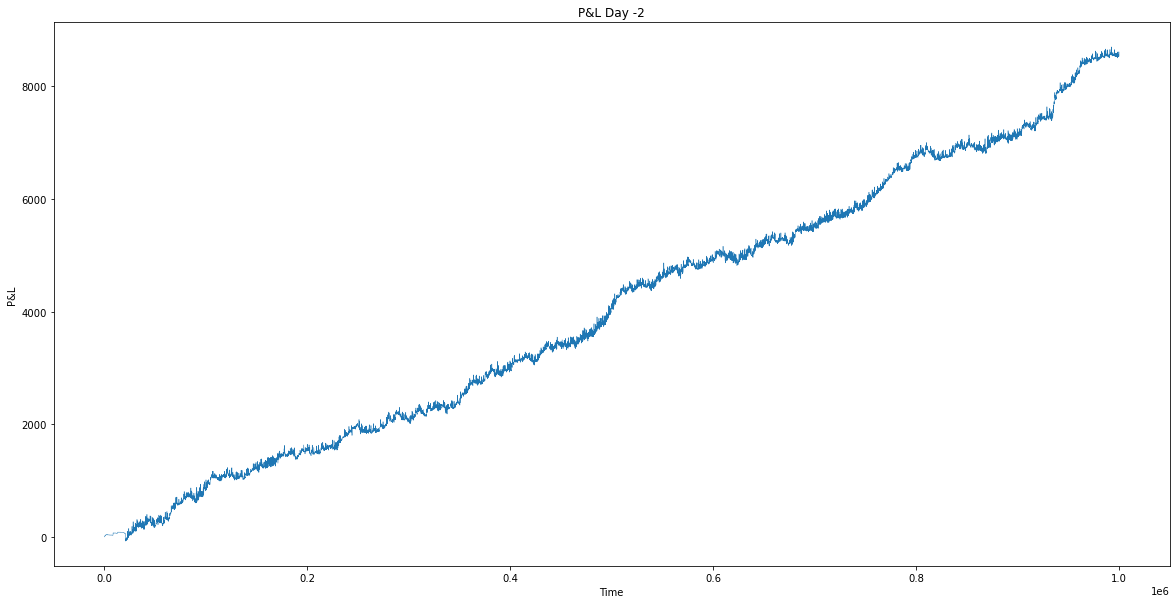

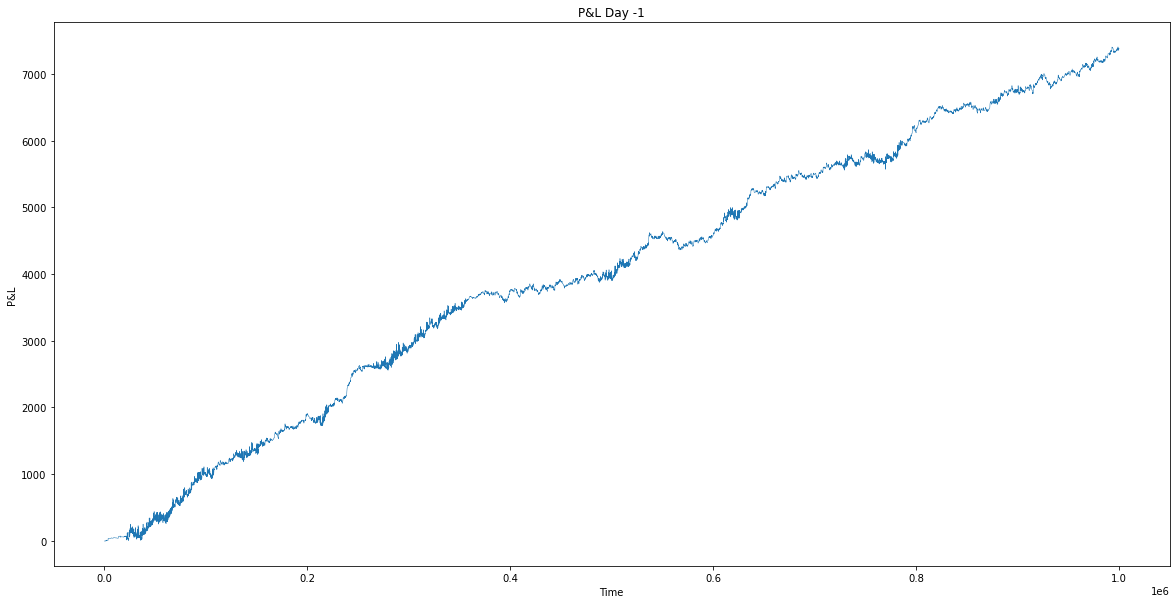

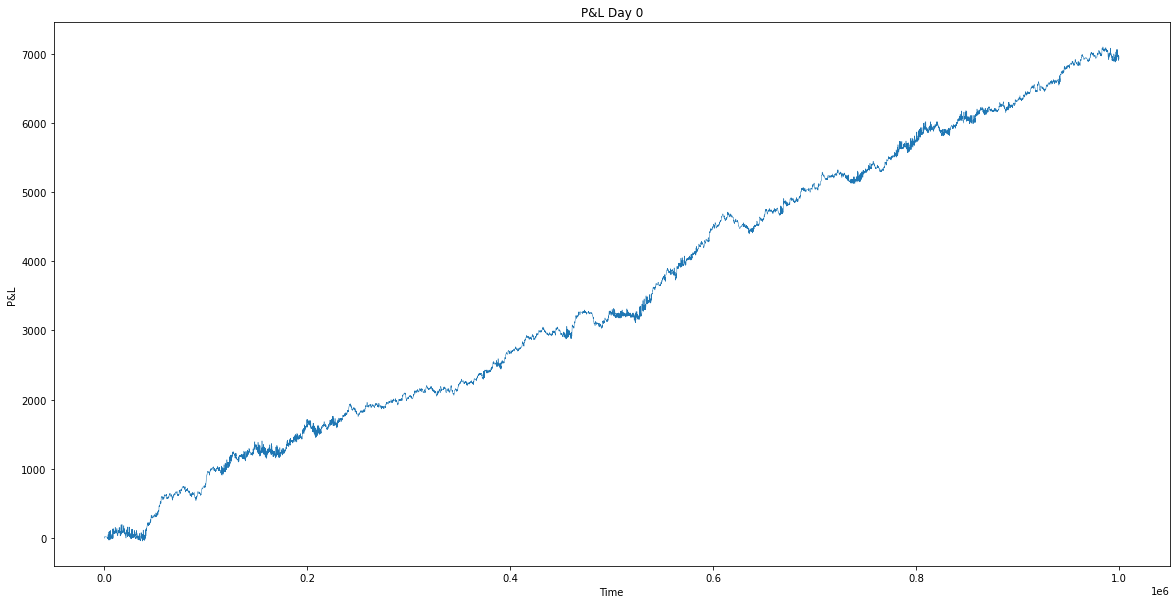

In [7]:
for day, data in outputs.items():
    plt.plot(data.mtm_value['Value'] , linewidth = 0.5)
    plt.xlabel('Time')
    plt.ylabel('P&L')
    plt.title('P&L Day ' + str(day))
    plt.show()

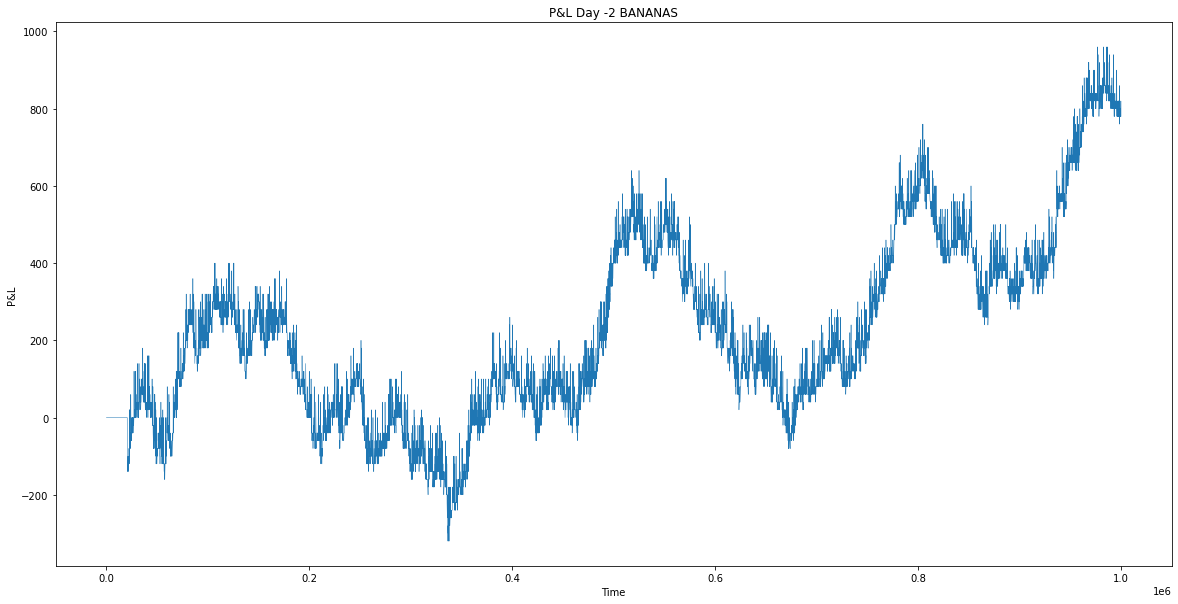

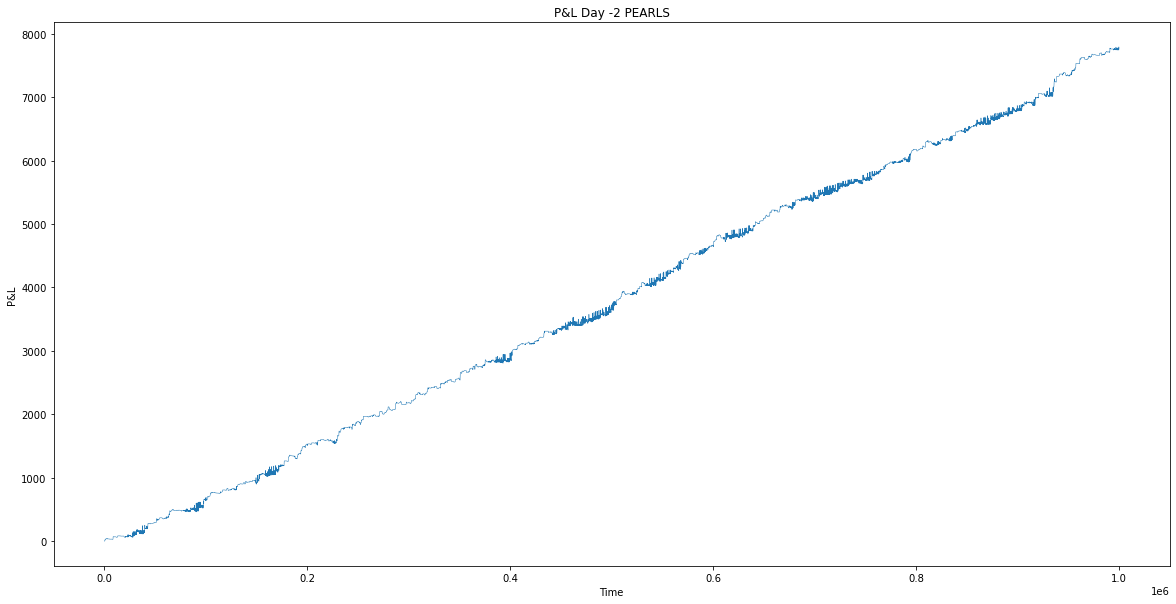

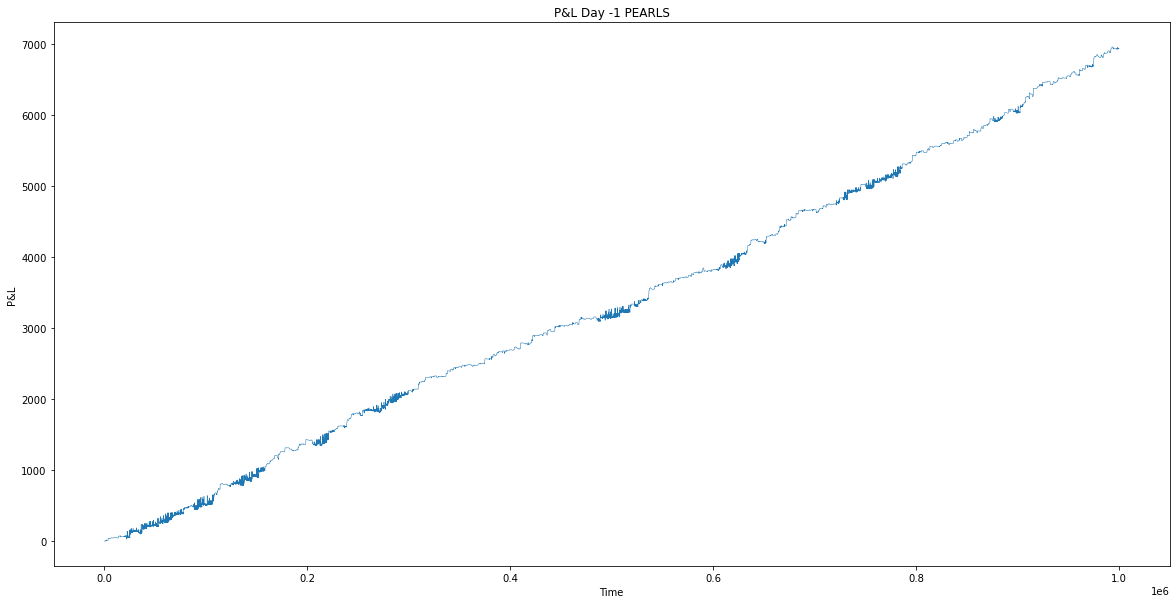

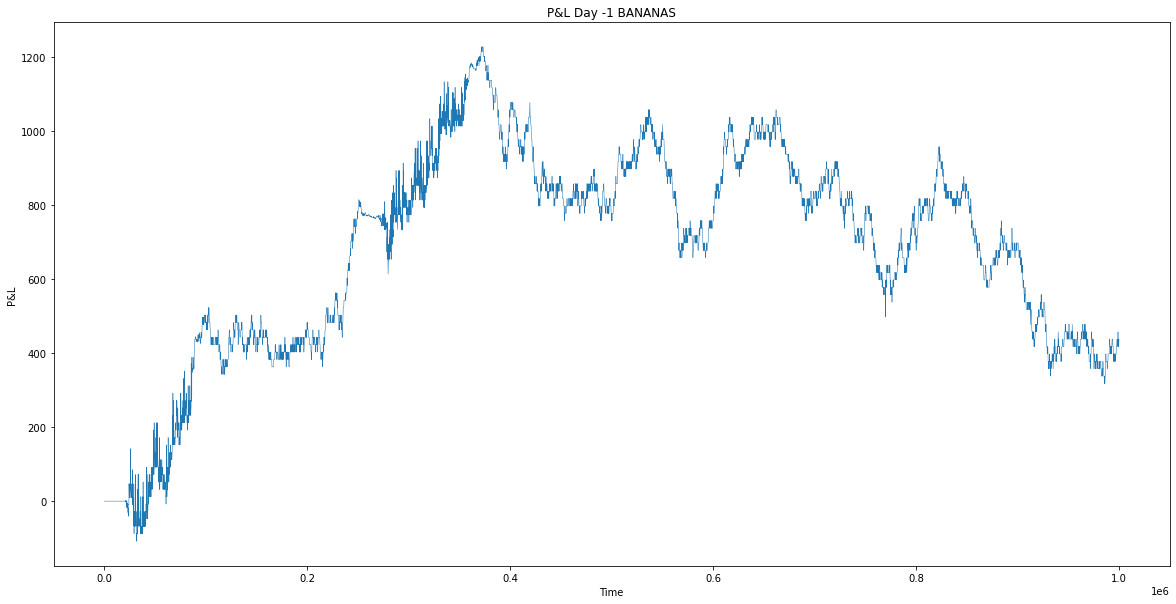

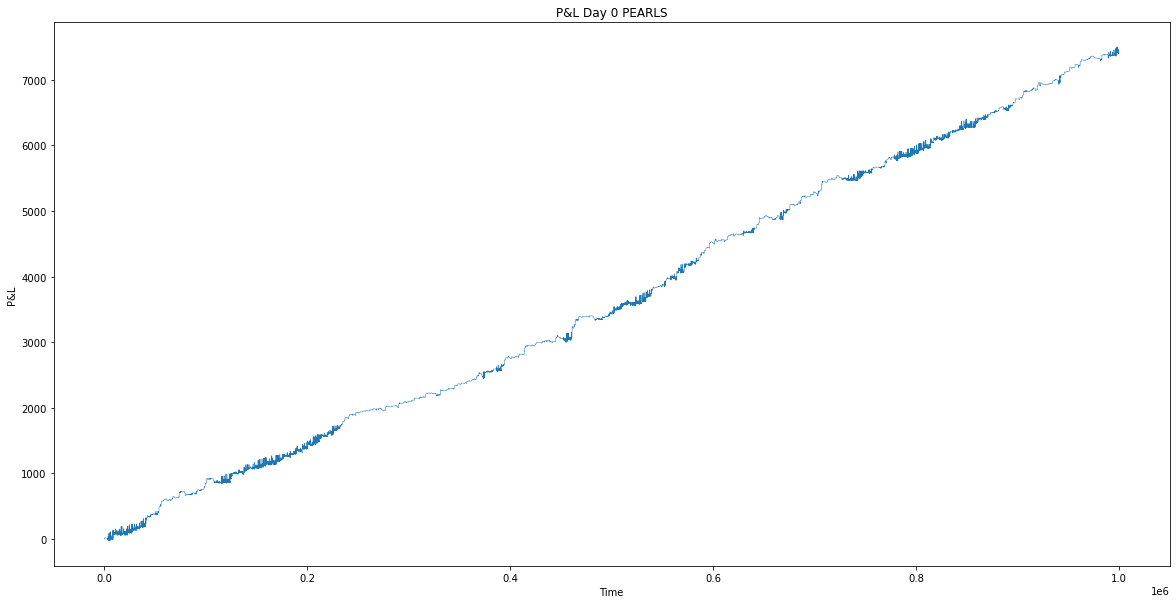

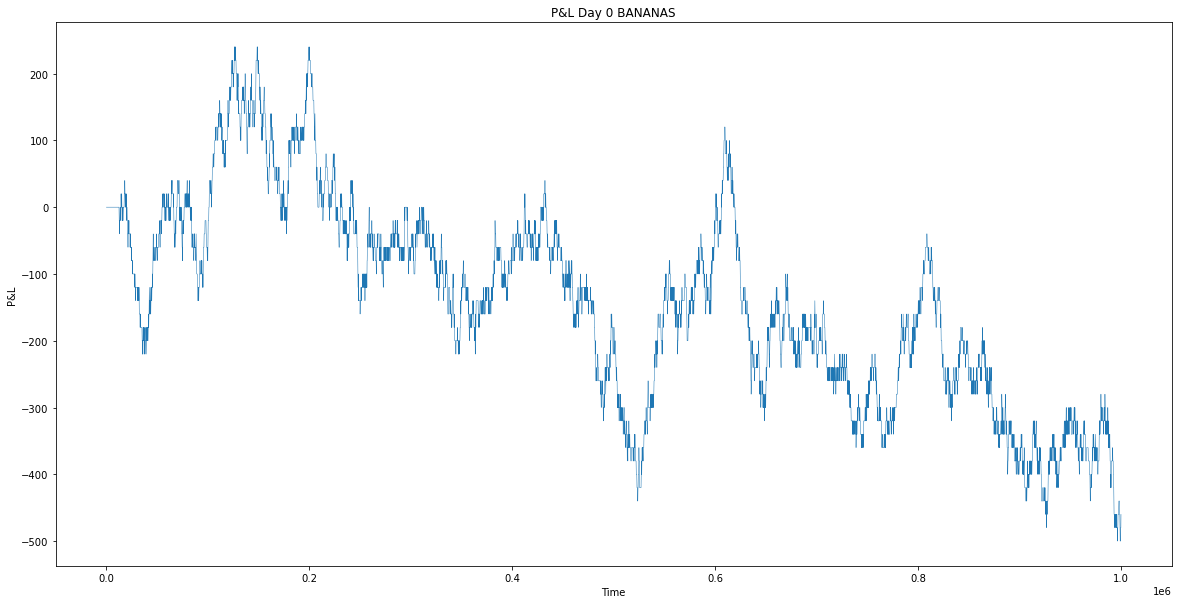

In [8]:
for day, data in outputs.items():
    for product in data.products:
        plt.plot(data.mtm_value['Value_'+product] , linewidth = 0.5)
        plt.xlabel('Time')
        plt.ylabel('P&L')
        plt.title('P&L Day ' + str(day)+' '+product)
        plt.show()